In [1]:
# Import libraries and Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

%matplotlib inline

###########################################################

# Loading Data-Set
label = pd.read_csv("secom_labels.txt", delim_whitespace=True, header=None)
features = pd.read_csv("secom_data.txt", delim_whitespace=True,header=None)

features = features.rename(columns={features.columns[i]: 'F'+ str(i) for i in range (590)}) # adding name to feature columns
label = label.rename(columns={0: 'L0', 1 :'date'})   # adding name to label column

############################################################

# Concatinating to separate files
df = pd.concat([features,label],axis=1, ignore_index=False)
#print(df.head()) # Preliminary inspection of data-set
#print(df.shape) # Preliminary inspection of data-set
#print(df.index) # Preliminary inspection of data-set

# Dropping columns with more than 10% missing data
df = df.dropna(thresh=len(df) - int(0.1 * len(df)), axis=1)
df = df.fillna(df.median())
df.L0.replace(-1,0, inplace=True) # Converting label column to binary [0,1]

# Building label vectore (y) and feature matrix(X)
y = df['L0']
X = df.drop(['L0','date'], axis=1)

C:\Users\JI-HWAN. CHOI\AppData\Local\Temp\ipykernel_13980\3284739679.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


In [2]:
# Employing Lasso regularization approach to reduce feature matrix dimenssion
lasso = Lasso(alpha=0.2,normalize=False)
lasso_coef = lasso.fit(X, y).coef_
print('Total number of remaining features:')
print(len(lasso_coef[lasso_coef!=0.0]))

# Making a list from selected features
val = lasso_coef[lasso_coef!=0.0]
key, = np.where(lasso_coef!=0.0)
feature_list = X.columns[key]
val_plt = np.multiply(val,1000)
feature_list = feature_list.tolist()
feature_column = key.tolist()
val = val.tolist()
print('List of selected features via Lasso dimenssion reduction:')
print(feature_list)

# revising feature matrix based on LASSO features reduction
X = X[feature_list]

Total number of remaining features:
41
List of selected features via Lasso dimenssion reduction:
['F0', 'F1', 'F3', 'F21', 'F22', 'F23', 'F24', 'F59', 'F67', 'F88', 'F90', 'F137', 'F140', 'F159', 'F160', 'F161', 'F162', 'F188', 'F296', 'F297', 'F363', 'F418', 'F419', 'F423', 'F433', 'F468', 'F480', 'F482', 'F483', 'F484', 'F485', 'F486', 'F488', 'F489', 'F499', 'F500', 'F510', 'F511', 'F521', 'F572', 'F589']


c:\Users\JI-HWAN. CHOI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


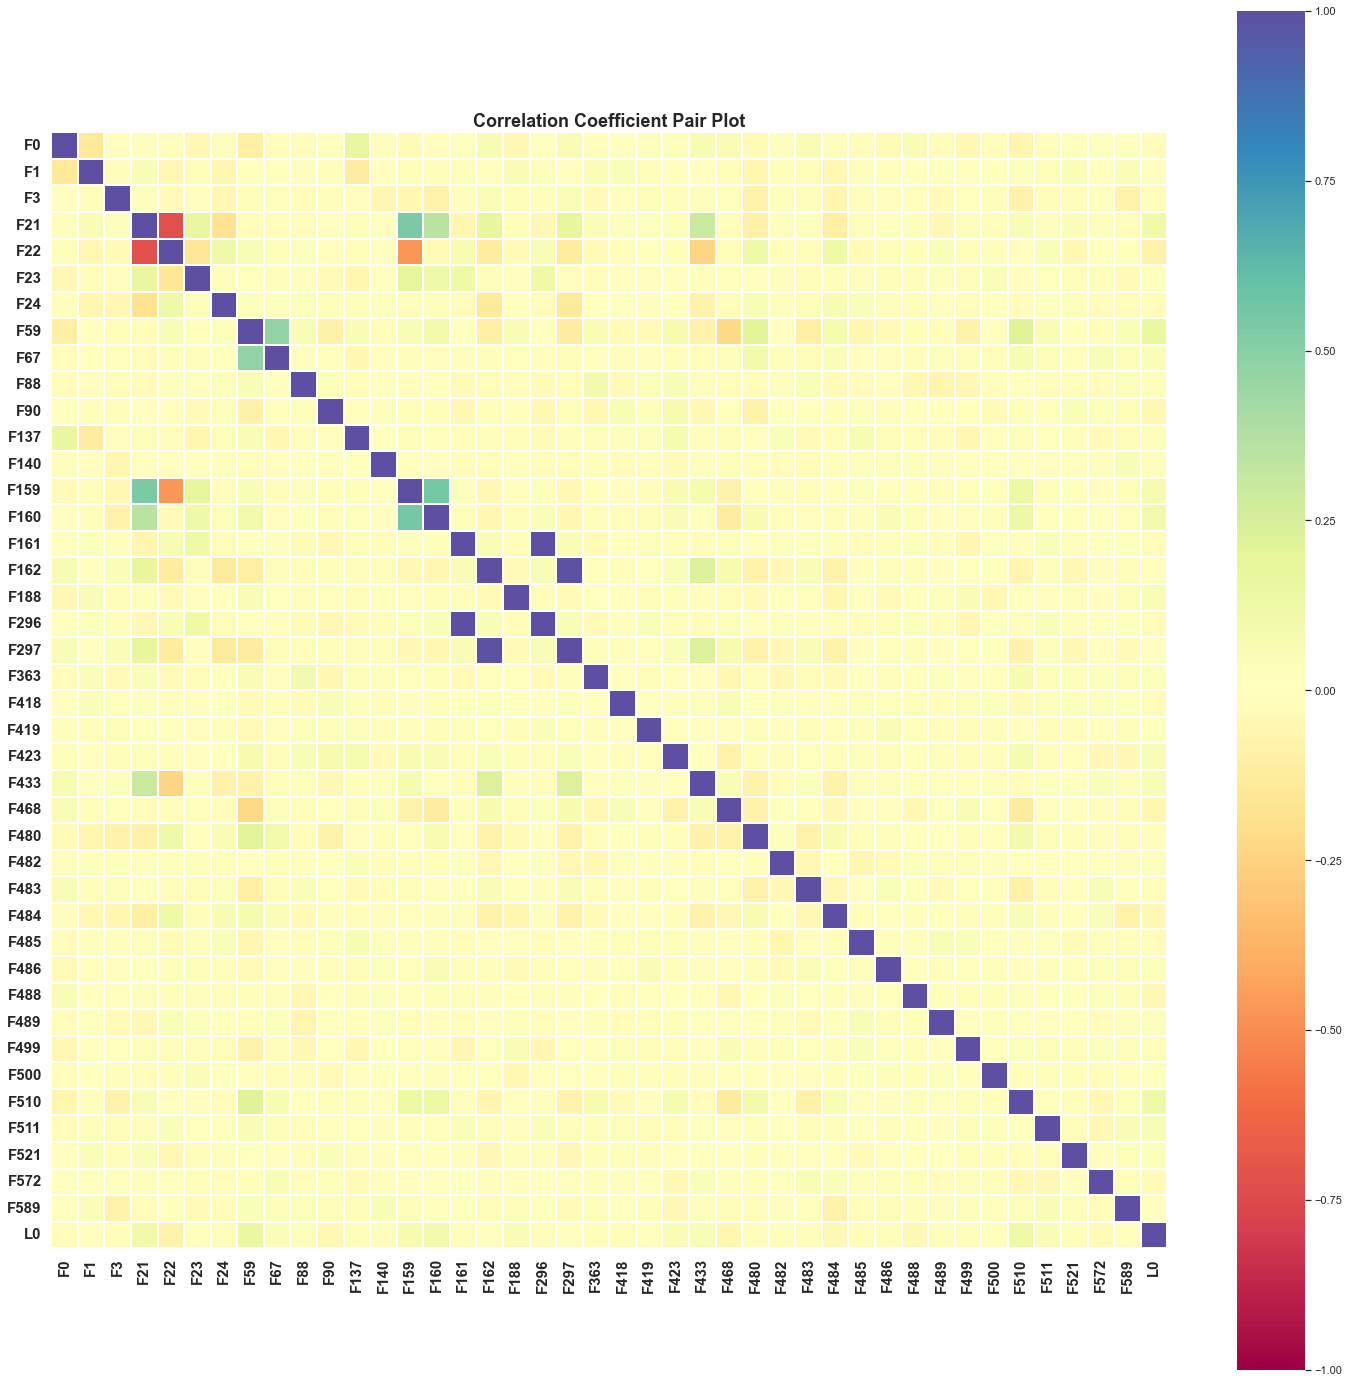

In [8]:
# Making correlation coefficients pair plot of all feature in order to identify degenrate features
plt.figure(figsize=(25,25))
df1 = pd.concat([X,y],axis=1, ignore_index=False) 
ax = plt.axes()
corr = df1.corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=False, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
plt.xticks(rotation=90,fontweight="bold", size=15) 
plt.yticks(rotation=0,fontweight="bold", size=15) 
plt.title('Correlation Coefficient Pair Plot', fontweight="bold", size=18)
plt.savefig('pcp.png')
plt.show()

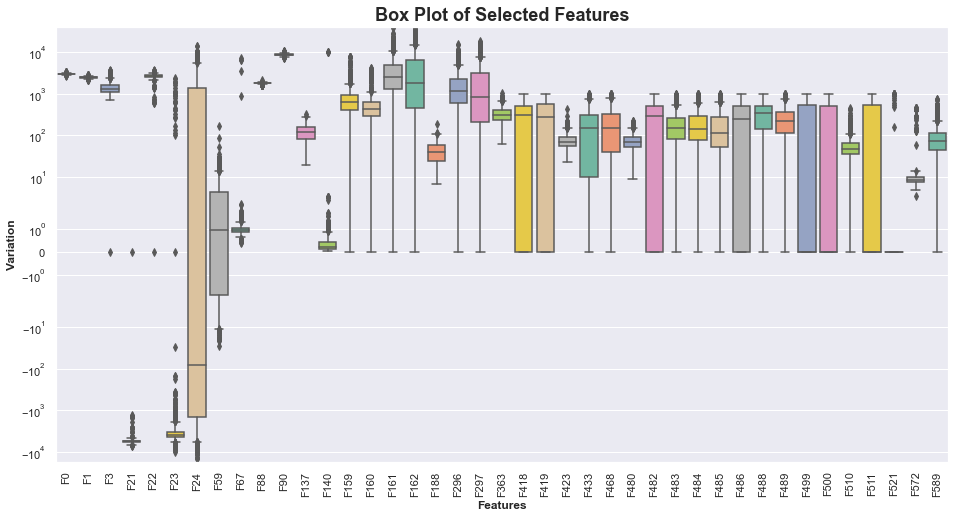

In [9]:
# Making box plot to explore features variations and outliers
plt.figure(figsize=(16,8))
sns.set()
sns.boxplot(data=X, orient="v", palette="Set2")
plt.xlabel('Features',fontweight="bold", size=12)
plt.ylabel('Variation',fontweight="bold", size=12)
plt.title('Box Plot of Selected Features', fontweight="bold", size=18)
plt.yscale('symlog')
plt.xticks(rotation=90)
plt.savefig('BoxPlot.png');plt.show()

In [10]:
# Exploratory Data Analysis
# Plotting total products against failed product in histogram format  
bins = 30
for feature in feature_list:
    tf = feature
    plt.figure()
    plt.hist(df1[tf], bins = bins, color='m',label = 'Total',alpha=0.5)
    plt.hist(df1[tf][df1['L0'] == 1], bins = bins, color='b',label = 'Fail')

    plt.xlabel(tf);plt.ylabel('Production')
    plt.title('Feature ID:'+tf,fontweight="bold", size=12)
    plt.yscale('log')

    plt.legend();plt.savefig(tf+'.png')
    plt.close()



Higher fail ratio: 0.069
Lower fail ratio: 0.025
Ratio difference: 0.044


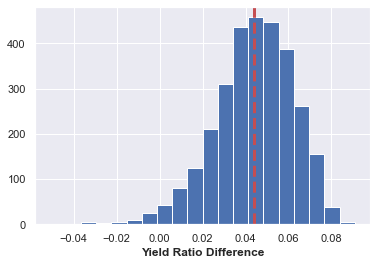

Mean ratio decrease: 0.044
95% Confidence interval: [0.00489341 0.07469717]
P-value: 0.5206666666666667


In [11]:
# Statistical Analysis & Hypothesis Testing
num_replica = 3000
bs_replica = np.empty(num_replica)
ht_feature = 'F484'
threshold = 680

lower_range = df1[(df1[ht_feature]>threshold) ]
higher_range = df1[(df1[ht_feature]<=threshold)]

lower_range_ratio = len(lower_range[lower_range['L0'] == 1])/len(lower_range)
higher_range_ratio = len(higher_range[higher_range['L0'] == 1])/len(higher_range)
ratio_diff = higher_range_ratio-lower_range_ratio

print('Higher fail ratio:',"%.3f" % higher_range_ratio)
print('Lower fail ratio:',"%.3f" % lower_range_ratio)
print('Ratio difference:', "%.3f" % ratio_diff)

# Bootstrapping
for i in range(num_replica):
    lr_bs = lower_range.sample(frac=1,replace=True)
    hr_bs = higher_range.sample(frac=1,replace=True)
    
    lr_bs_r = len(lr_bs[lr_bs['L0'] == 1])/len(lr_bs)
    hr_bs_r = len(hr_bs[hr_bs['L0'] == 1])/len(hr_bs)
    ratio_diff_bs = hr_bs_r - lr_bs_r
    bs_replica[i] = ratio_diff_bs  


# Histogram plot    
plt.hist(bs_replica, bins=20)
plt.axvline(ratio_diff, color='r', linestyle='dashed', linewidth=3)
plt.xlabel('Yield Ratio Difference',fontweight="bold", size=12)
plt.savefig('Hypothesis.png')
plt.show()   

# Calculating P-value
print('Mean ratio decrease:',"%.3f" % np.mean(bs_replica))
print('95% Confidence interval:', (np.percentile(bs_replica,[2.5,97.5])))
print('P-value:', np.sum(bs_replica > (ratio_diff))/num_replica)


In [15]:
# Preparing data for time series analysis
# Concatinating two separate files
df2 = pd.concat([features,label],axis=1, ignore_index=False)

# Converting to time series format
df2.date = pd.to_datetime(df2.date)
df2.set_index('date', inplace=True)


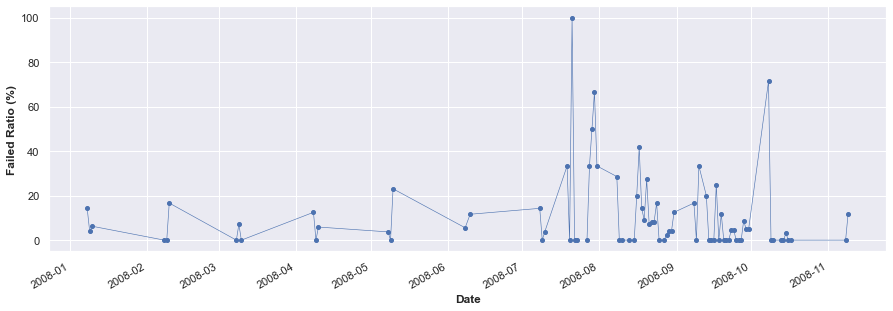

In [19]:
# Resampling yield data based on daily information 
failed_product = df2.L0[df2['L0']==1].resample('D').count()
total_product = df2.L0[df2['L0']==-1].resample('D').count()

failed_ratio = failed_product * 100 / total_product
failed_ratio = failed_ratio.dropna()

# Visualizaion of daily production failed ratio
sns.set()

failed_ratio.plot(style='bo-', markersize=4, linewidth = 0.6, figsize=(15,5))
plt.xlabel('Date', fontweight="bold", size=12)
plt.ylabel('Failed Ratio (%)', fontweight="bold", size=12)
plt.grid(True);plt.savefig('100Days.png')
plt.show()

In [ ]:
# Indexing dates with more than 50% failed ratio
date_index = failed_ratio[failed_ratio >= 50]

# Plotting F484 for date_index
df2['F484'].loc['2008-07-21'].hist(alpha=0.7, label = '2008-07-21')
df2['F484'].loc['2008-07-29'].hist(alpha=0.7, label = '2008-07-29')
df2['F484'].loc['2008-07-30'].hist(alpha=0.7, label = '2008-07-30')
df2['F484'].loc['2008-10-08'].hist(alpha=0.7, label = '2008-10-08')
plt.axvline(680, color='r', linestyle='dashed', linewidth=3) # Thresold in hypothesis testing (Previouse section)
plt.xlabel('F484', fontweight="bold", size=12)
plt.legend()
plt.savefig('F484_Worst.png')
plt.show()

In [21]:
#########################################################
# Claculating default Ratio
passed = len(df[df['L0']==0])
failed = len(df[df['L0']==1])
ratio = float(failed/(passed+failed))
print('Number of passed sample:', passed)
print('Number of failed sample:', failed)
print('Default Ratio (failed/total) :', "%.3f" % ratio)

#########################################################
# Splitting data to train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)
X_test = X_test.values # Coverting dataframe to matrix for compatibility purpose

# Under-sampling of overer-represented calss (pass) 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0) 
X_us, y_us = rus.fit_resample(X_train, y_train) #https://abluesnake.tistory.com/116에서 찾아볼것

print('########################################')
print('Size of training data-set:', X_train.shape)
print('Size of under sampling data_set:', X_us.shape)

# Over-sampling of under-represented calss (fail)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_os, y_os = ros.fit_resample(X_train, y_train) #https://abluesnake.tistory.com/116에서 찾아볼것
print('Size of overer sampling data_set:', X_os.shape)

Number of passed sample: 1463
Number of failed sample: 104
Default Ratio (failed/total) : 0.066
########################################
Size of training data-set: (1096, 41)
Size of under sampling data_set: (146, 41)
Size of overer sampling data_set: (2046, 41)


In [23]:
# Import ML Libraries 

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import classification_report
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 12, 4

In [24]:
# XGB Model

def xgb_model(alg, X_matrix, y_vector, test_matrix, test_vector, useTrainCV=True, useTestSet = False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_matrix, y_vector)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_matrix, y_vector, eval_metric='auc')   
    
    #Predict training set:
    dtrain_predictions = alg.predict(X_matrix)
    dtrain_predprob = alg.predict_proba(X_matrix)[:,1]
    #Print model report:
    print ("\nModel Report on Training Set")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_vector, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_vector, dtrain_predprob))
    # Determine the false positive and true positive rates
    fpr_train, tpr_train, _ = roc_curve(y_vector, dtrain_predprob)
    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr_train, tpr_train, label='Training ROC curve (area = %0.2f)' % metrics.roc_auc_score(y_vector, dtrain_predprob))
       
    ############################################################    
    if useTestSet:   
        #Predict test set:
        dtest_predictions = alg.predict(test_matrix)
        dtest_predprob = alg.predict_proba(test_matrix)[:,1] 
        #Print model report:
        print ("\nModel Report on Test Set")
        print ("Accuracy : %.4g" % metrics.accuracy_score(test_vector, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(test_vector, dtest_predprob))               
        # Determine the false positive and true positive rates
        fpr_test, tpr_test, _ = roc_curve(test_vector, dtest_predprob) 
        # Plot of a ROC curve for a specific class
        plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % metrics.roc_auc_score(test_vector, dtest_predprob))
    
    ############################################################    
    plt.plot([0, 1], [0, 1], 'k--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
    plt.legend(loc="lower right"); plt.savefig('ROC.png'); plt.show()

    
    ############################################################
    # Calculating feature importance
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('Feature_Importance.png'); plt.show()


Model Report on Training Set
Accuracy : 0.9599
AUC Score (Train): 0.994617


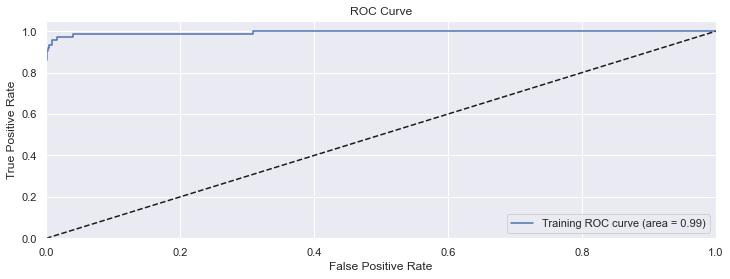

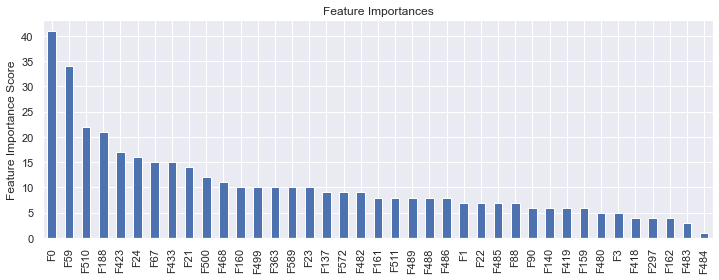

In [25]:
# First run with default model parameters 

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 reg_lambda=1,     
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model(xgb1, X_train, y_train, X_test, y_test)


In [26]:
# Tunning max_depth & min_child_weight (Part I)

param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
     learning_rate =0.1, n_estimators=200, max_depth=5, min_child_weight=1, gamma=0, 
     subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, objective= 'binary:logistic', 
     nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='roc_auc',n_jobs=4, 
     cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.31762514, 0.24374809, 0.22958593, 0.22305708, 0.19624062,
         0.37044315, 0.31216779, 0.28544364, 0.23787503, 0.24196119,
         0.38508325, 0.33481765, 0.29123259, 0.25004115, 0.24495373,
         0.40652871, 0.31117935, 0.26839018, 0.2601088 , 0.21174307]),
  'std_fit_time': array([0.0288449 , 0.0061673 , 0.01389687, 0.02136044, 0.0190061 ,
         0.04277545, 0.0217705 , 0.01623049, 0.01692877, 0.0145342 ,
         0.0408805 , 0.03572982, 0.00661078, 0.01600882, 0.02232591,
         0.02666638, 0.01773863, 0.01202431, 0.02457132, 0.02399208]),
  'mean_score_time': array([0.00518641, 0.00478716, 0.00498691, 0.00459938, 0.00460629,
         0.00578794, 0.00478721, 0.00498672, 0.00518608, 0.0047873 ,
         0.00518599, 0.00558505, 0.00498672, 0.00518565, 0.00598397,
         0.00538564, 0.00518517, 0.00538526, 0.0054872 , 0.00518832]),
  'std_score_time': array([9.77019028e-04, 3.98969665e-04, 3.23406696e-07, 7.89139053e-04,
         4.81421119e-04

In [27]:
# Tunning max_depth & min_child_weight (Part II)
param_test2 = {
 'max_depth':[6,7,8]
 }
gsearch2 = GridSearchCV(estimator = XGBClassifier(
     learning_rate=0.1, n_estimators=200, max_depth=7,
     min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
     param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
     
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.2876359 , 0.21183338, 0.18031802]),
  'std_fit_time': array([0.02142204, 0.01256146, 0.01894726]),
  'mean_score_time': array([0.0057848 , 0.0045876 , 0.00458727]),
  'std_score_time': array([0.00116353, 0.00048906, 0.00048928]),
  'param_max_depth': masked_array(data=[6, 7, 8],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}],
  'split0_test_score': array([0.63186992, 0.63186992, 0.63186992]),
  'split1_test_score': array([0.62508711, 0.62508711, 0.62508711]),
  'split2_test_score': array([0.7261324, 0.7261324, 0.7261324]),
  'split3_test_score': array([0.67222222, 0.67222222, 0.67222222]),
  'split4_test_score': array([0.75098039, 0.75098039, 0.75098039]),
  'mean_test_score': array([0.68125841, 0.68125841, 0.68125841]),
  'std_test_score': array([0.05010174, 0.05010174, 0.05010174]),
  'rank_test_score': array([1, 1, 1])},
 {'max_depth': 6},


In [28]:
# Tunning max_depth & min_child_weight (Part III)
param_test3 = {
 'min_child_weight':[8,9,10,11,12,13,14,15,16]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(
     learning_rate=0.1, n_estimators=200, max_depth=6,
    min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.19367738, 0.18510666, 0.17803025, 0.17763047, 0.16087322,
         0.15618553, 0.154392  , 0.13963175, 0.12696409]),
  'std_fit_time': array([0.00586455, 0.00123665, 0.02017546, 0.00681016, 0.00487281,
         0.0060107 , 0.00556628, 0.00454589, 0.01001823]),
  'mean_score_time': array([0.00478735, 0.00418906, 0.00438843, 0.004987  , 0.00478735,
         0.00508828, 0.00418887, 0.00458784, 0.0038908 ]),
  'std_score_time': array([0.00039895, 0.00039885, 0.00048912, 0.00063068, 0.00039871,
         0.0004863 , 0.00039907, 0.00048887, 0.00049004]),
  'param_min_child_weight': masked_array(data=[8, 9, 10, 11, 12, 13, 14, 15, 16],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 8},
   {'min_child_weight': 9},
   {'min_child_weight': 10},
   {'min_child_weight': 11},
   {'min_child_weight': 12},
   {'min_child_weight':

In [29]:
# Tunning gamma
param_test4 = {
 'gamma':[i/10.0 for i in range(0,8)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(
     learning_rate =0.1, n_estimators=200, max_depth=6,
    min_child_weight=14, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.14999738, 0.1438149 , 0.14600968, 0.16256499, 0.17253847,
         0.15338974, 0.15777783, 0.15358915]),
  'std_fit_time': array([0.00799379, 0.00506261, 0.00486953, 0.01934891, 0.02462414,
         0.0137097 , 0.01273116, 0.0113887 ]),
  'mean_score_time': array([0.00458817, 0.00438824, 0.00478783, 0.00458794, 0.00458789,
         0.00438871, 0.00478721, 0.0037899 ]),
  'std_score_time': array([0.00048885, 0.00048869, 0.00039907, 0.00048846, 0.00048901,
         0.00048918, 0.00039899, 0.00039887]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4},
   {'gamma': 0.5},
   {'gamma': 0.6},
   {'gamma': 0.7}],
  'split0_test_score': array([0.70081301, 0.69203252, 0.69203252, 0.68747967, 0.68747967,
    

In [30]:
# Tunning subsample & colsample_bytree (Part I)
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(
     learning_rate =0.1, n_estimators=200, max_depth=6,
    min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.12067595, 0.1214746 , 0.13204684, 0.15498848, 0.13454404,
         0.13225293, 0.15439248, 0.15947928, 0.13683901, 0.14471669,
         0.15449309, 0.17862906, 0.1529963 , 0.15977817, 0.1576848 ,
         0.16496415]),
  'std_fit_time': array([0.00282067, 0.00650597, 0.00299877, 0.02085598, 0.01542395,
         0.00967037, 0.01528617, 0.01227321, 0.00724687, 0.01020511,
         0.00980537, 0.00776429, 0.01234801, 0.00613121, 0.00709712,
         0.00645059]),
  'mean_score_time': array([0.00398936, 0.0043889 , 0.00558548, 0.00478697, 0.00478702,
         0.00478578, 0.00478735, 0.0045886 , 0.00518656, 0.00429211,
         0.00478721, 0.00558505, 0.00478697, 0.00458779, 0.00418878,
         0.00428991]),
  'std_score_time': array([0.00063045, 0.00048815, 0.00241061, 0.00074629, 0.0007463 ,
         0.00039841, 0.00074633, 0.00079745, 0.00074629, 0.00040094,
         0.00074642, 0.00048869, 0.00074661, 0.00048854, 0.00039899,
         0.00040004]),
  'param_c

In [31]:
# Tunning subsample & colsample_bytree (Part II)
param_test6 = {
 'subsample':[i/100.0 for i in range(70,95,5)],
 'colsample_bytree':[i/100.0 for i in range(70,95,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(
     learning_rate =0.1, n_estimators=200, max_depth=6,
    min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.13583903, 0.1254704 , 0.12975702, 0.14142709, 0.14342189,
         0.13324704, 0.13684087, 0.13843546, 0.14531517, 0.14910836,
         0.13673825, 0.14292455, 0.15091324, 0.16318774, 0.16358418,
         0.14344659, 0.14740872, 0.14691143, 0.15748367, 0.16765761,
         0.14451752, 0.1554915 , 0.15698581, 0.16406779, 0.15908275]),
  'std_fit_time': array([0.01062011, 0.00116583, 0.0053676 , 0.00738208, 0.00827005,
         0.00396016, 0.00732613, 0.0057765 , 0.00316453, 0.00531492,
         0.00317624, 0.00425032, 0.01041167, 0.00549851, 0.01178511,
         0.00364114, 0.00092367, 0.00416791, 0.00532922, 0.00544794,
         0.01101314, 0.00478682, 0.00731952, 0.00981254, 0.01589437]),
  'mean_score_time': array([0.00439105, 0.00398912, 0.00418873, 0.00418878, 0.00429025,
         0.00478687, 0.00458784, 0.00438838, 0.00418901, 0.00478706,
         0.00438857, 0.00438795, 0.00498686, 0.004986  , 0.00458784,
         0.00458827, 0.00418892, 0.00458794, 0.

In [32]:
# Tunning reg_alpha
param_test7 = {
 'reg_alpha':[0.0, 0.1,0.2,0.3,0.4,0.5]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(
     learning_rate =0.1, n_estimators=200, max_depth=6,
    min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.75,reg_alpha=0, reg_lambda=1,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([0.13922539, 0.13474064, 0.13763409, 0.13664017, 0.14781017,
         0.13763804]),
  'std_fit_time': array([0.00784281, 0.00559299, 0.00776875, 0.0065417 , 0.00757957,
         0.01667145]),
  'mean_score_time': array([0.00538573, 0.00438843, 0.00409045, 0.00458755, 0.00438848,
         0.00458817]),
  'std_score_time': array([0.00048873, 0.00048854, 0.00048713, 0.00048844, 0.00048879,
         0.00048846]),
  'param_reg_alpha': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.0},
   {'reg_alpha': 0.1},
   {'reg_alpha': 0.2},
   {'reg_alpha': 0.3},
   {'reg_alpha': 0.4},
   {'reg_alpha': 0.5}],
  'split0_test_score': array([0.70731707, 0.70569106, 0.70439024, 0.69723577, 0.70731707,
         0.70894309]),
  'split1_test_score': array([0.62090592, 0.60522648, 0.61811847, 0.59860627, 0.61428571,
         0.61881533])

In [33]:
X_train = X_train.values


Model Report on Training Set
Accuracy : 0.9389
AUC Score (Train): 0.944121

Model Report on Test Set
Accuracy : 0.9299
AUC Score (Test): 0.721774


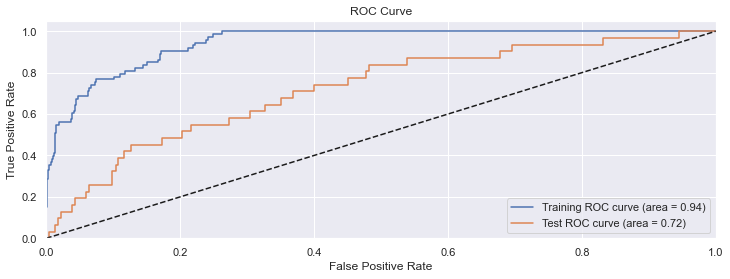

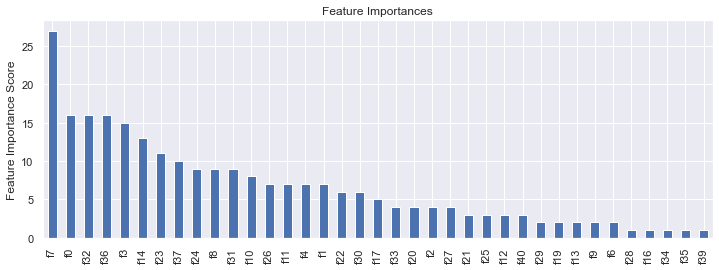

In [34]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=6,
 min_child_weight=14,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_alpha=0.5,
 reg_lambda=1,   
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model(xgb2, X_train, y_train, X_test, y_test, useTestSet = True)